# Cartopy tutorial: Vector to vector

[Introduction](../../introduction.ipynb) > [Geospatial data](../geospatial_data.ipynb) > Vector to vector

## Transforming coordinate values (points)
Conversion of a point in one coordinate system to another is an example of a vector-to-vector transformation.

In cartopy we can convert points from one coordinate system to another using the [transform_point](https://scitools.org.uk/cartopy/docs/latest/crs/index.html#cartopy.crs.CRS.transform_point) and [transform_points](https://scitools.org.uk/cartopy/docs/latest/crs/index.html#cartopy.crs.CRS.transform_points) methods on a CRS.

In [1]:
import cartopy.crs as ccrs

In [7]:
osgb = ccrs.OSGB()
geod = ccrs.Geodetic()

# Convert from Ordnance Survey GB to lon/lat:
easting = 291813.424
northing = 92098.387

lon, lat = geod.transform_point(
    x=easting, y=northing, src_crs=osgb)
print(lon, lat)

-3.533885175986329 50.71841091955379


## Projecting lines

When it comes to "transforming" a line or other geometry, we could choose to manually transform each of the vertices, but that requires us to deal with things like the antimeridian and appropriate interpolation.

Cartopy has functionality specifically designed for this purpose. It uses a numerical tolerance to determine appropriate interpolation and whether to "cut" the line because it crossed the antimeridian.

Because this is a numerical approximation and not an exact transformation, the name of the method on a cartopy Projection is [project_geometry](https://scitools.org.uk/cartopy/docs/latest/crs/index.html#cartopy.crs.Projection.project_geometry):

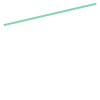

In [33]:
import shapely.geometry as sgeom

new_york = [-74.0060, 40.7128]
honolulu = [-157.8583, 21.3069]

line = sgeom.LineString([new_york, honolulu])
pc = ccrs.PlateCarree()

lines = pc.project_geometry(line, pc)
lines

That wasn't too exciting, but let's take a look at it on a map:

<IPython.core.display.Javascript object>


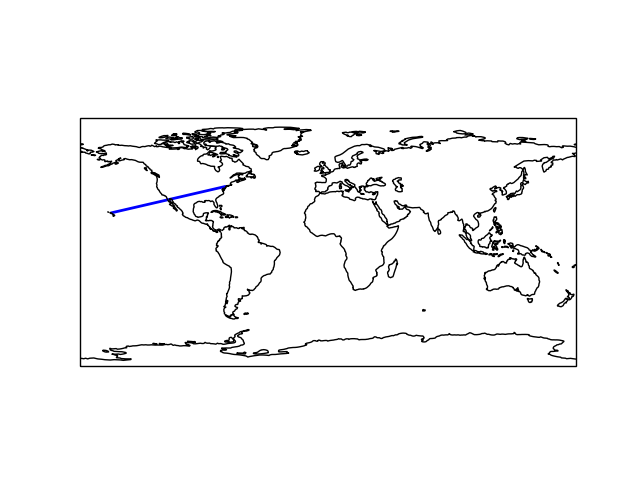

In [34]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
ax = plt.axes(projection=pc)
ax.add_geometries(
    [lines], pc,
    edgecolor='blue', facecolor='none', lw=2)
ax.coastlines()
plt.show()

If we wanted to represent the line as a great circle rather than a straight line in projected (Plate Carree) space we can change the source CRS to Geodetic:

<IPython.core.display.Javascript object>


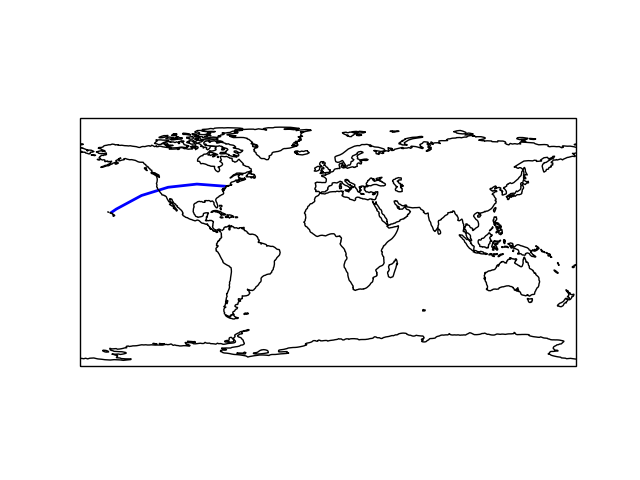

In [35]:
lines = pc.project_geometry(line, geod)

plt.figure()
ax = plt.axes(projection=pc)
ax.add_geometries(
    [lines], pc,
    edgecolor='blue', facecolor='none', lw=2)
ax.coastlines()
plt.show()

**Exercise**: Construct a LineString between Yokohama (139.6380, 35.4437) and San Fransisco (-122.4194, 37.7749).
When projecting this line, what is the difference between using Plate Carree and Geodetic as the source coordinate system?

*Extension*: Use cartopy to draw a map showing both of these lines.

*Extension*: Devise a way of constructing the LineString such that it crosses the dateline when using ``project_geometry`` and Plate Carree.

<IPython.core.display.Javascript object>


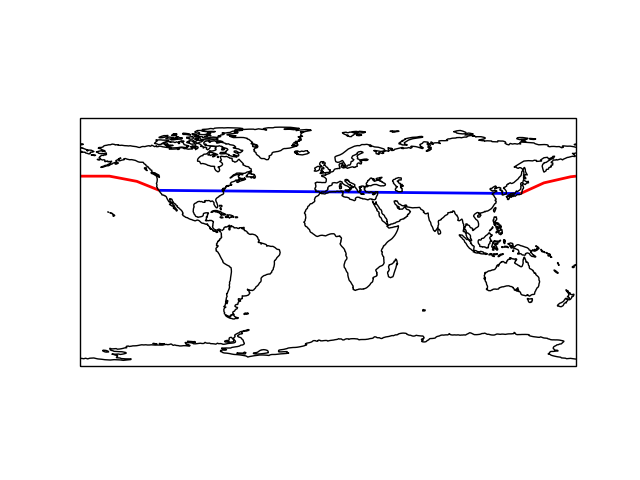

In [106]:
# EXERCISE SOLUTION

line = sgeom.LineString([(139.6380, 35.4437), (-122.4194, 37.7749)])
pc = ccrs.PlateCarree()

pc_lines = pc.project_geometry(line, ccrs.PlateCarree())
geod_lines = pc.project_geometry(line, ccrs.Geodetic())


plt.figure()
ax = plt.axes(projection=pc)

# Add the Plate Carree line in blue
ax.add_geometries(
    [pc_lines], pc,
    edgecolors='blue', facecolor='none', lw=2)

# Add the Geodetic line in red
ax.add_geometries(
    [geod_lines], pc,
    edgecolors='red', facecolor='none', lw=2)

ax.coastlines()
plt.show()

## Projecting geometries

Projecting geometries is much the same as projecting lines. Let's construct a circle of radius 20 to demonstrate:

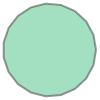

In [66]:
import numpy as np

npts = 20
radius = 20
phi = np.linspace(0, 2*np.pi, npts)
coords = np.stack([np.cos(phi), np.sin(phi)], axis=-1)
circle = sgeom.Polygon(coords * radius)
circle

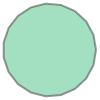

In [67]:
prj_circle = pc.project_geometry(circle, geod)
prj_circle

To really see the power of this, let's project this geometry to a Plate Carree shifted by 180 degrees:

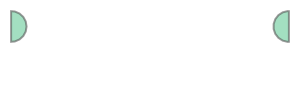

In [68]:
pc_180 = ccrs.PlateCarree(central_longitude=180)
prj_circle = pc_180.project_geometry(circle, geod)
prj_circle

See how cartopy has realised that it needs to cut the circle up. We can see precicely why when we look at the map:

<IPython.core.display.Javascript object>


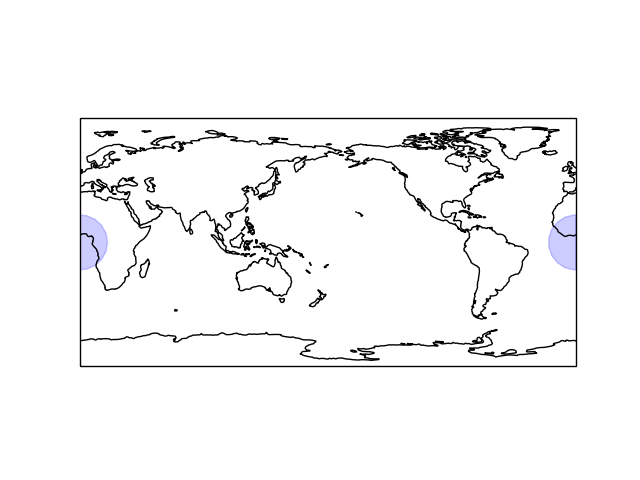

In [75]:
plt.figure()
ax = plt.axes(projection=pc_180)
ax.add_geometries(
    [prj_circle], pc_180,
    edgecolor='blue', facecolor='blue', alpha=0.2)
ax.coastlines()
plt.show()

On the sphere the winding order of a polygon is important. Cartopy uses a counter-clockwise (CCW) winding order to be consistent with the [simple geometries](https://gis.stackexchange.com/a/147971/9354) conventions. If we reverse the order of the circle's coordinates and project that, we get a very different (but equally valid) polygon:

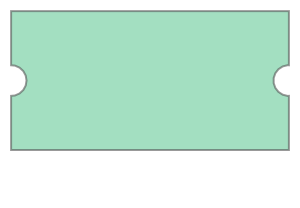

In [77]:
inverse_circle = sgeom.Polygon(coords[::-1] * radius)
pc_180 = ccrs.PlateCarree(central_longitude=180)
pc_180.project_geometry(inverse_circle, geod)

## Geographical distances (Geodesic distances)

Another common vector-to-vector transformation is to compute distances between two points on the sphere.

Cartopy wraps GeographicLib in ``cartopy.geodesic`` to give this functionality.
(**Note**: this interface is entirely undocumented, and it *could* change in the future)

In [144]:
import cartopy.geodesic

geod = cartopy.geodesic.Geodesic()

nyc = [-73.9866136, 40.7306458]
london = [-0.1276474, 51.5073219]

# Solve the "inverse" Geodetic problem to compute the distance
# between two points. This solution is even more accurate than
# the traditional Vincenty formulation.
distance, azi_0, azi_1 = np.array(geod.inverse(nyc, london).T)

print('Geodesic distance between NYC and London: {:.0f}km'
      .format(distance[0] / 1000))

Geodesic distance between NYC and London: 5583km


We can compute multiple distances at the same time. Let's use that to compute distances along a line:

In [143]:
san_fran = [-122.4629897, 37.7647993]
track = [san_fran, nyc, london]

distances, azi_0, azi_1 = np.array(
    geod.inverse(track[:-1], track[1:]).T)

print('Segment distances (m): ', distances)

print('Geodesic distance between San Fransisco and '
      'London (via NYC): {:.0f}km'
      .format(distances.sum() / 1000))

Segment distances (m):  [4144339.97629077 5582728.55686424]
Geodesic distance between San Fransisco and London (via NYC): 9727km


**Exercise**: What is the approximate average speed (in km/h) that Fogg must travel in order to achieve his 80 day target?

*Reminder:* Fogg plans to depart from London, and his main stops are planned to be: Suez, Bombay, Calcutta, Hong-Kong, Yokohama, San Fransisco, New York City, London.

*Extension*: Assuming Fogg plans to arrive after exactly 80 days, and that he travels at a constant speed along the route, compute how many days into his journey he will be when he arrives at each of the main stops.

In [3]:
# Some approximate locations of each of the cities are provided.
places = {'London': {'lon': -0.1278, 'lat': 51.5074},
          'Suez': {'lon': 32.5498, 'lat': 29.9668},
          'Bombay': {'lon': 72.8777, 'lat': 19.0760},
          'Calcutta': {'lon': 88.3639, 'lat': 22.5726},
          'Hong Kong': {'lon': 114.1095, 'lat': 22.3964},
          'Yokohama': {'lon': 139.6380, 'lat': 35.4437},
          'San Fransisco': {'lon': -122.4194, 'lat': 37.7749},
          'New York City': {'lon': -74.0060, 'lat': 40.7128},
         }

In [169]:
# EXERCISE SOLUTION

destinations = [
    'London', 'Suez', 'Bombay', 'Calcutta', 'Hong Kong',
    'Yokohama', 'San Fransisco', 'New York City', 'London']

waypoints = [(places[place]['lon'], places[place]['lat'])
             for place in destinations]

distances, azi_0, azi_1 = np.array(
    geod.inverse(waypoints[:-1], waypoints[1:]).T)

print("Approximate distance of Fogg's proposed route: {:.0f} km"
      .format(distances.sum() / 1000))
print("Average speed required over 80 days: {:.1f} km/h"
      .format(distances.sum() / 1000 / (80 * 24)))


# Extension
print('\n--- extension ---')
print('Planned locations after N days:')
cumulative_distances = np.cumsum(distances)
for dest, distance in zip(destinations[1:], cumulative_distances):
    m_per_day = 17.2 * 1000 * 24
    print(' {:13s}: \t{:2.0f} days'.format(dest, distance/m_per_day))
    

Approximate distance of Fogg's proposed route: 33039 km
Average speed required over 80 days: 17.2 km/h

--- extension ---
Planned locations after N days:
 Suez         : 	 9 days
 Bombay       : 	19 days
 Calcutta     : 	23 days
 Hong Kong    : 	29 days
 Yokohama     : 	36 days
 San Fransisco: 	56 days
 New York City: 	67 days
 London       : 	80 days


### Geometry predicates

We can bring all that we've learnt together to answer the question "How much of the proposed route is over land?".

Let's first create a LineString that represents the route as a collection of *great circles*.

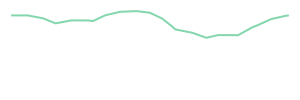

In [22]:
import shapely.geometry as sgeom
import cartopy.crs as ccrs

destinations = [
    'London', 'Suez', 'Bombay', 'Calcutta', 'Hong Kong',
    'Yokohama', 'San Fransisco', 'New York City', 'London']

waypoints = [(places[place]['lon'], places[place]['lat'])
             for place in destinations]

line = sgeom.LineString(waypoints)
pc = ccrs.PlateCarree()

foggs_plan = pc.project_geometry(line, ccrs.Geodetic())
foggs_plan

Now, let's get hold of a set of geometries that represent "land". Cartopy has convenience routines to help us do that, but let's start with the manual approach:

In [12]:
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom

land_shp_fname = '../../resources/land/ne_110m_land.shp'
# Cartopy actually has a convenient interface to auto-download
# this (and many other) file(s) if we want.
# land_shp_fname = cartopy.io.shapereader.natural_earth(
#     resolution='110m', category='physical', name='land')

land_geoms = list(shpreader.Reader(land_shp_fname).geometries())

Now, let's combine this collection of geometries into a single shapely MultiPolygon using ``shapely.ops.unary_union``. This actually results in an invalid geometry - it isn't clear if this is a problem with the dataset or the underlying geometry library, but either way the quick fix is to "buffer the geometry by 0".

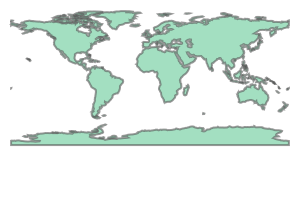

In [23]:
from shapely.ops import unary_union

land = unary_union(land_geoms).buffer(0)

land

Finally we are ready to start using this geometry:

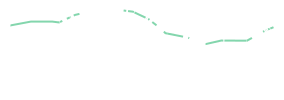

In [25]:
foggs_land_plan = land.intersection(foggs_plan)
foggs_land_plan

In [34]:
import numpy as np
import cartopy.geodesic

def linestring_distance(geometry):
    """
    A function that returns the geodetic distance of a [Multi]LineString
    
    """
    ls_type = (sgeom.LineString, sgeom.MultiLineString)
    if not isinstance(geometry, ls_type):
        raise TypeError('The given geometry is not a [Multi]LineString')

    if isinstance(geometry, sgeom.MultiLineString):
        return sum(linestring_distance(geom) for geom in geometry.geoms)
    else:
        coords = np.array(geometry.coords)
        geod = cartopy.geodesic.Geodesic()
        distances, azi_0, azi_1 = np.array(
            geod.inverse(coords[:-1], coords[1:]).T)
        return distances.sum()

**Exercise: ** Using the function above, calculate the distance of the planned route over land.

*Extension*: Use the shapefile of 1880s countries found in ``../../resources/1880_countries/cntry1880.shp`` to find the names of the countries that Fogg plans to pass through (note: ``cartopy.shapereader.Reader`` has a ``records`` method, and each of the records have ``.attributes['NAME']`` and ``.geometry``).

In [45]:
# EXERCISE SOLUTION

distance = linestring_distance(foggs_plan)
land_distance = linestring_distance(foggs_land_plan)
print("Fogg's planned route is approximately {:.0f} km. "
      "{:.0f} km of that is over land"
      .format(distance / 1000, land_distance / 1000))


print('\n--- Extension ---')
land_shp_fname = '../../resources/1880_countries/cntry1880.shp'

country_records = list(shpreader.Reader(land_shp_fname).records())

passed_countries = []
for country in country_records:
    if country.geometry.intersects(foggs_plan):
        passed_countries.append(country.attributes['NAME'])

print('Countries that Fogg will pass through with the proposed route')
print('\n'.join(sorted(passed_countries)))

Fogg's planned route is approximately 33039 km. 15071 km of that is over land

--- Extension ---
Countries that Fogg will pass through with the proposed route
Annam
Arabia
Austria Hungary
Bulgaria
Burma
Canada
Egypt
France
Germany
Greece
India
Ireland
Japan
Laos
Lombardy
Manchu Empire
Oman
Ottoman Empire
Switzerland
Trucial Oman
United Kingdom
United States of America


## Saving vector data

AIM: Save as GeoJSON (WGS84)

## Rendering vector data in the browser

AIM: Use folium to produce a map of the route.

In [46]:
import folium 


def map_set_bounds_from_geometry(m, geom):
    """
    Given a folium map an a geometry, set the map's
    bounds to show it
    
    """
    geom_bounds = geom.bounds
    # Folium is looking for [[y0, x0], [y1, x1]]
    bounds = [geom_bounds[:2][::-1],
              geom_bounds[2:][::-1]]
    m.fit_bounds(bounds)


m = folium.Map()
    
map_set_bounds_from_geometry(m, foggs_plan)

style_function = lambda x: {'color': "#808000",
                            'line_opacity': 0.5}
m.add_child(
    folium.GeoJson(
        foggs_plan.__geo_interface__,
        name="Fogg's proposed route",
        style_function=style_function,
    )
)